# **Diabetes Readmission Prediction**
**Objective:** Predict whether a patient will be readmitted to the hospital within 30 days using EHR data.


## Libraries and Installation

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [4]:
!pip install ucimlrepo

## Dataset

We are using the dataset from UCI: **"Diabetes 130-US hospitals for years 1999–2008"**

X --> input features

y --> Target columns (readmitted)

In [14]:
from ucimlrepo import fetch_ucirepo

# Fetching the dataset from the repo
diabetes_dataset = fetch_ucirepo(id=296)

# Extracting features and targets as pandas DataFrames
X = diabetes_dataset.data.features
y = diabetes_dataset.data.targets

# Displaying the first 5 rows of the features
X.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes


## Data Exploration

In [19]:
#Summary of Data types
X.dtypes.value_counts()

,count
object,36
int64,11


In [15]:
print("Feature shape:", X.shape)          #Shape of features
print("Target shape:", y.shape)           #Shape of Targets
print("Columns:", X.columns.tolist())

Feature shape: (101766, 47)
Target shape: (101766, 1)
Columns: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [18]:
#Checking th Target variable
y['readmitted'].value_counts()

,count
readmitted,
NO,54864
>30,35545
<30,11357


##### Observation



1.   < 30 --> readmitted within 30 days (will be labelled as 1)
2.   \> 30 --> readmitted after 30 days
3.   NO - not readmitted



In [13]:
#checking for any missing values
missing = X.isnull().sum()
missing[missing > 0]

,0
race,2273
weight,98569
payer_code,40256
medical_specialty,49949
diag_1,21
diag_2,358
diag_3,1423
max_glu_serum,96420
A1Cresult,84748


* Dropping columns with too many null values to keep things clean
* Dropping payer_code as it not useful in practice
* The diagnosis codes (diag_1, diag_2, diag_3) could add predictive value, and since they don’t have too many missing values, we’ll impute them instead of dropping.

In [21]:
#Dropping columns with too many missing values
cols_to_drop = ['weight', 'max_glu_serum', 'A1Cresult',
                'medical_specialty', 'payer_code']

X_cleaned = X.drop(columns=cols_to_drop)

In [22]:
#Counting unique values in each column
X_cleaned.nunique().sort_values()

,0
examide,1
citoglipton,1
acetohexamide,2
tolbutamide,2
diabetesMed,2
troglitazone,2
metformin-rosiglitazone,2
metformin-pioglitazone,2
glipizide-metformin,2
glimepiride-pioglitazone,2


This helps identify:

* Binary features
* High-cardinality categorical variables (like diag_1, diag_2, diag_3)

In [24]:
#imputing missing Diagnosis codes and race values
X_cleaned[['diag_1', 'diag_2', 'diag_3']] = X_cleaned[['diag_1', 'diag_2', 'diag_3']].fillna('Unknown')
X_cleaned['race'] = X_cleaned['race'].fillna('Unknown')

##### Converting Target variable into Binary

The original readmitted column contains 3 values:

* '<30' -->  patient was readmitted within 30 days
* 'NO'  -->  not readmitted
* '>30' -->  readmitted after 30 days

We’ll convert it to:

* 1 if '<30'
* 0 otherwise

In [25]:
# Create binary label: 1 if readmitted within 30 days, else 0
Y = y['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

In [26]:
#checking distribution
Y.value_counts()

,count
readmitted,
0,90409
1,11357


##Encoding


We need to convert categorical columns into numeric form using One-Hot Encoding

In [27]:
#Identifying categorical columns
cat_cols = X_cleaned.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", cat_cols)

Categorical columns: ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


In [28]:
#Encoding categorical columns
X_encoded = pd.get_dummies(X_cleaned, columns=cat_cols, drop_first=True)

In [29]:
print("Encoded feature shape:", X_encoded.shape)
X_encoded.head()

Encoded feature shape: (101766, 2330)


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
0,6,25,1,1,41,0,1,0,0,0,...,False,True,False,False,False,False,False,False,True,False
1,1,1,7,3,59,0,18,0,0,0,...,True,True,False,False,False,False,False,False,False,True
2,1,1,7,2,11,5,13,2,0,1,...,False,True,False,False,False,False,False,False,True,True
3,1,1,7,2,44,1,16,0,0,0,...,True,True,False,False,False,False,False,False,False,True
4,1,1,7,1,51,0,8,0,0,0,...,False,True,False,False,False,False,False,False,False,True


Observation:

*   All columns encoded into numerical values



##Model Training and Evaluation

We’ll split the data into:

* Training set (80%) — to train the model
* Testing set (20%) — to evaluate model performanc

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_encoded, Y, test_size=0.2, random_state=42, stratify=Y)

Random forest is used as it is a good, fast-performing model for tabluar data

In [31]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.8886214011987815

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.59      0.01      0.01      2271

    accuracy                           0.89     20354
   macro avg       0.74      0.50      0.48     20354
weighted avg       0.86      0.89      0.84     20354



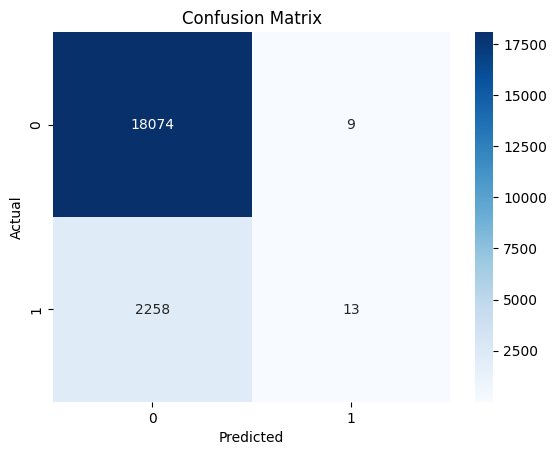

In [32]:
#Evaluating the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Optional: Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [33]:
import pickle

# Save the model to a file
with open('rf_readmission_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model saved successfully.")

Model saved successfully.


In [36]:
!pip install nbconvert

!jupyter nbconvert --to html diabetic_readmission.ipynb

[NbConvertApp] WARNING | pattern 'diabetic_readmission.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--ex